<a href="https://colab.research.google.com/github/zahra75koosha/zahra-koosha/blob/master/handwritten_hoda_dataset_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 uninstall tensorflow
!pip3 install tensorflow.gpu==2.0.0


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
%cd /content/drive/My Drive/hoda
%ls

/content/drive/My Drive/hoda
hoda_dataset_helper.py  __pycache__/  RemainingSamples.cdb  test/  train/


In [0]:
from hoda_dataset_helper import read_hoda
from hoda_dataset_helper import __read_hoda_dataset
from hoda_dataset_helper import __read_hoda_cdb

import os
import numpy as np
import matplotlib.pyplot as plt

# %matplotlib inline

np.random.seed(2)

from keras.regularizers import l2
from keras import regularizers
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

from tensorflow.keras import Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten

Reading Train , Test , Remain dataset


In [0]:
# Reading train dataset 
X_train, Y_train = __read_hoda_dataset(dataset_path='./train/Train 60000.cdb',
                                images_height=32,
                                images_width=32,
                                one_hot=False ,
                                reshape=False)

# reading test dataset
X_test, Y_test = __read_hoda_dataset(dataset_path='./test/Test 20000.cdb',
                              images_height=32,
                              images_width=32,
                              one_hot=False,
                              reshape=False)

# Reading remain dataset
X_remain, Y_remain = __read_hoda_dataset('./RemainingSamples.cdb',
                                             images_height=32,
                                             images_width=32,
                                             one_hot=False,
                                             reshape=False)

In [0]:
# concat train and remain dataset
x_train=np.concatenate([X_train, X_remain])
y_train=np.concatenate([Y_train,Y_remain])


In [670]:
print(f'Number of the train samples are : {x_train.shape}')
print(f'Number of the test samples are : {X_test.shape}')


Number of the train samples are : (82352, 32, 32, 1)
Number of the test samples are : (20000, 32, 32, 1)


Preprocessing

In [0]:
# rescale data
x_train = x_train / 255.0
X_test = X_test /255.0


In [0]:
# Convert class vectors to binary class matrices.
y_train  =   to_categorical(y_train, num_classes = 10)
Y_test   =   to_categorical(Y_test, num_classes = 10)


In [673]:
print(f'shape of Y_train : {y_train.shape}')
print(f'shape of Y_test : {Y_test.shape}')

shape of Y_train : (82352, 10)
shape of Y_test : (20000, 10)


Split train dataset to train and validation 

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val= train_test_split(x_train,y_train,test_size=0.1, random_state=2, shuffle=True)

In [675]:
print(f'Number of the validation samples are : {x_val.shape}')
print(f'Shape of Y_val : {y_val.shape}')

Number of the validation samples are : (8236, 32, 32, 1)
Shape of Y_val : (8236, 10)


Visiual some data

In [0]:
# reading train image
train_images, train_labels = __read_hoda_cdb('./train/Train 60000.cdb')

# reading test image
test_images, test_labels = __read_hoda_cdb('./test/Test 20000.cdb')

# reading train image
remaining_images, remaining_labels = __read_hoda_cdb('./RemainingSamples.cdb')


In [0]:
train_img =np.concatenate([train_images,remaining_images])
label_img =np.concatenate([train_labels,remaining_labels])

In [678]:
train_img.shape

(82352,)

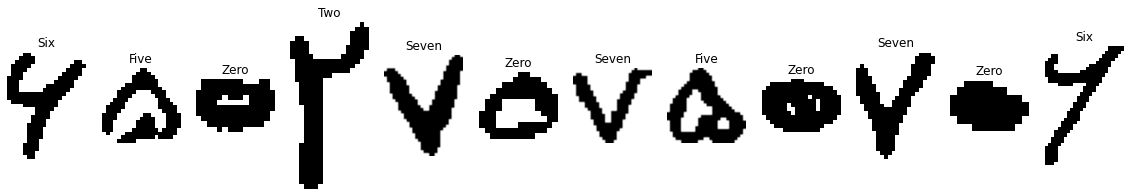

In [679]:
CLASS_NAMES = np.array(['zero','one','two', 'three','four','five','six', 'seven', 'eight',  'nine',])

plt.figure(figsize=(20,10))
for n in range(12):
      ax = plt.subplot(1,12,n+1)
      plt.imshow(train_img[n], cmap=plt.cm.Greys)
      plt.title(CLASS_NAMES[label_img[n]].title())
      plt.axis('off')


CNN Model

In [680]:
model= Sequential()

# block 1
model.add(Conv2D(32,(5,5), activation='relu', padding='same', input_shape=(32,32,1)))
model.add(Conv2D(32,(5,5), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

# block 2
model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# block 3
model.add(Conv2D(32,(3,3), activation='relu', padding='same'))

model.add(Flatten())
model.add(Dense(512, activation='relu' , kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))


model.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_182 (Conv2D)          (None, 32, 32, 32)        832       
_________________________________________________________________
conv2d_183 (Conv2D)          (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_184 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_88 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_185 (Conv2D)          (None, 8, 8, 32)        

In [0]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping=tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")

lrr = ReduceLROnPlateau(monitor='val_accuracy', 
                        patience=2, 
                        verbose=1, 
                        factor=0.4 ,
                        min_lr=0.00001)

my_callbacks=[lrr, early_stopping]


In [0]:
# set optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [685]:
# train model
epochs = 25
batch_size = 32
result=model.fit(x_train, y_train,epochs=epochs, batch_size=batch_size, validation_data=(x_val,y_val), verbose=1, callbacks=my_callbacks)

Train on 74116 samples, validate on 8236 samples
Epoch 1/25
74116/74116 [==============================] - 31s 424us/sample - loss: 1.2303 - accuracy: 0.8861 - val_loss: 0.3146 - val_accuracy: 0.9584
Epoch 2/25
74116/74116 [==============================] - 30s 410us/sample - loss: 0.2308 - accuracy: 0.9651 - val_loss: 0.1712 - val_accuracy: 0.9721
Epoch 3/25
74116/74116 [==============================] - 30s 411us/sample - loss: 0.1418 - accuracy: 0.9750 - val_loss: 0.1159 - val_accuracy: 0.9801
Epoch 4/25
74116/74116 [==============================] - 31s 414us/sample - loss: 0.1101 - accuracy: 0.9803 - val_loss: 0.1012 - val_accuracy: 0.9814
Epoch 5/25
74116/74116 [==============================] - 31s 416us/sample - loss: 0.0954 - accuracy: 0.9831 - val_loss: 0.0859 - val_accuracy: 0.9851
Epoch 6/25
74116/74116 [==============================] - 30s 410us/sample - loss: 0.0869 - accuracy: 0.9847 - val_loss: 0.0808 - val_accuracy: 0.9864
Epoch 7/25
74116/74116 [=====================

In [686]:
model.evaluate(X_test, Y_test, verbose=1)

20000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.03844197035431862, 0.9905]

In [687]:
model.evaluate(x_val, y_val, verbose=1)

8236/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.02983246557731154, 0.9940505]

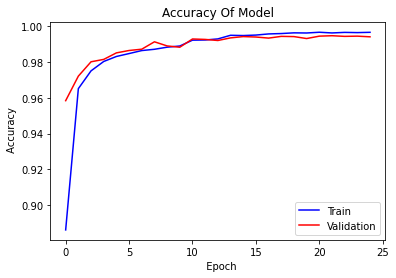

In [688]:
# plot train and validation accuracy

plt.plot(result.history['accuracy'], color='b', label='training accuracy')
plt.plot(result.history['val_accuracy'], color='r', label='validation accuracy')
plt.title('Accuracy Of Model')
plt.ylabel(' Accuracy')
plt.xlabel('  Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

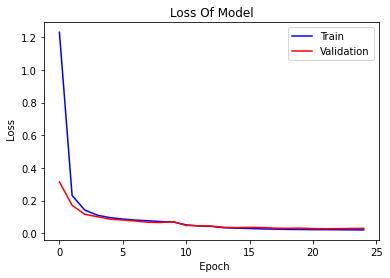

In [689]:
# plot train and validation accuracy

plt.plot(result.history['loss'], color='b', label='training loss')
plt.plot(result.history['val_loss'], color='r', label='validation loss')
plt.title('Loss Of Model')
plt.ylabel(' Loss')
plt.xlabel('  Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [0]:
# predict test dataset

import pandas as pd
from sklearn.utils import shuffle

results = model.predict(X_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results)

In [0]:
results = shuffle(results)

In [711]:
results

19290    9
7340     3
373      0
8718     4
1200     0
        ..
5381     2
16       0
6075     3
3011     1
5315     2
Length: 20000, dtype: int64

In [712]:
Y_test[8718]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [0]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("cnn_digit_dataset.csv",index=False)